In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import os
from google.colab import files


In [2]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Upload and Load the UNSW-NB15 Dataset
def load_dataset():
    """
    This function prompts the user to upload the UNSW-NB15 dataset files
    """
    print("Please upload the UNSW-NB15 dataset CSV files...")

    # Ask user to upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files were uploaded. Creating synthetic data instead.")
        return create_synthetic_data()

    # Get the uploaded filenames
    filenames = list(uploaded.keys())
    print(f"Uploaded files: {filenames}")

    # Try to identify training and testing files
    train_file = None
    test_file = None

    for filename in filenames:
        if 'train' in filename.lower():
            train_file = filename
        elif 'test' in filename.lower():
            test_file = filename

    # If we couldn't identify specific train/test files, use all files
    if train_file is None or test_file is None:
        print("Couldn't identify specific training and testing files.")
        print("Combining all uploaded files and creating train/test split...")

        all_data = pd.DataFrame()
        for filename in filenames:
            if filename.endswith('.csv'):
                df = pd.read_csv(filename)
                all_data = pd.concat([all_data, df], ignore_index=True)

        if all_data.empty:
            print("No valid CSV files were uploaded. Creating synthetic data instead.")
            return create_synthetic_data()

        # Create train/test split
        train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)
        print("Created train/test split from combined data.")
    else:
        # Load the identified files
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)
        print(f"Loaded training data from {train_file} and testing data from {test_file}.")

    return train_data, test_data

def create_synthetic_data():
    """
    Create synthetic data similar to UNSW-NB15 for testing the pipeline
    """
    print("Creating synthetic data for testing the pipeline...")
    np.random.seed(42)
    n_samples = 10000

    # Features similar to those in UNSW-NB15
    synthetic_data = pd.DataFrame({
        'dur': np.random.exponential(1, n_samples),
        'proto': np.random.choice(['tcp', 'udp', 'icmp'], n_samples),
        'service': np.random.choice(['http', 'ftp', 'smtp', 'ssh', '-'], n_samples),
        'state': np.random.choice(['CON', 'INT', 'FIN', 'REQ'], n_samples),
        'spkts': np.random.poisson(10, n_samples),
        'dpkts': np.random.poisson(8, n_samples),
        'sbytes': np.random.poisson(500, n_samples),
        'dbytes': np.random.poisson(300, n_samples),
        'rate': np.random.exponential(0.5, n_samples),
        'sttl': np.random.randint(1, 255, n_samples),
        'dttl': np.random.randint(1, 255, n_samples),
        'sload': np.random.exponential(0.1, n_samples),
        'dload': np.random.exponential(0.1, n_samples),
        'sinpkt': np.random.exponential(0.01, n_samples),
        'dinpkt': np.random.exponential(0.01, n_samples),
        'sjit': np.random.exponential(0.1, n_samples),
        'djit': np.random.exponential(0.1, n_samples),
        'swin': np.random.randint(1000, 65535, n_samples),
        'dwin': np.random.randint(1000, 65535, n_samples),
        'stcpb': np.random.randint(10000, 4000000, n_samples),
        'dtcpb': np.random.randint(10000, 4000000, n_samples),
        'tcprtt': np.random.exponential(0.1, n_samples),
        'synack': np.random.exponential(0.05, n_samples),
        'ackdat': np.random.exponential(0.05, n_samples),
        'smean': np.random.poisson(40, n_samples),
        'dmean': np.random.poisson(40, n_samples),
        'ct_srv_src': np.random.poisson(2, n_samples),
        'ct_dst_ltm': np.random.poisson(2, n_samples),
        'is_ftp_login': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
        'ct_ftp_cmd': np.random.poisson(0.5, n_samples),
        'ct_flw_http_mthd': np.random.poisson(0.5, n_samples),
        'ct_src_ltm': np.random.poisson(2, n_samples),
        'ct_srv_dst': np.random.poisson(2, n_samples),
        'is_sm_ips_ports': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        # Target variable - 0 is normal, 1-9 are different attack types
        'label': np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], n_samples, p=[0.7, 0.06, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02])
    })

    # Split into train and test
    train_data, test_data = train_test_split(synthetic_data, test_size=0.2, random_state=42)
    print("Synthetic data created successfully.")

    return train_data, test_data

In [3]:

# Step 2: Preprocess the Data
def preprocess_data(train_data, test_data):
    # Let's first check the data
    print("Training data shape:", train_data.shape)
    print("Testing data shape:", test_data.shape)
    print("Training data columns:", train_data.columns.tolist())

    # Handle missing values if any
    train_data = train_data.fillna(0)
    test_data = test_data.fillna(0)

    # Identify target column - look for either 'label' or 'attack_cat' or 'class'
    target_columns = [col for col in train_data.columns if col.lower() in ['label', 'attack_cat', 'class', 'attack']]

    if len(target_columns) == 0:
        print("Warning: Could not identify target column. Please check your dataset structure.")
        # Let's assume the last column is the target
        target_column = train_data.columns[-1]
    else:
        # Use the first matching target column
        target_column = target_columns[0]

    print(f"Using '{target_column}' as the target column")

    # Identify categorical features
    categorical_columns = []
    for col in train_data.columns:
        if train_data[col].dtype == 'object' and col != target_column:
            categorical_columns.append(col)

    print(f"Categorical columns: {categorical_columns}")

    # Combine data for preprocessing
    all_data = pd.concat([train_data, test_data], axis=0)

    # One-hot encode categorical features
    all_data = pd.get_dummies(all_data, columns=categorical_columns)

    # Identify ID columns to exclude
    id_columns = [col for col in all_data.columns if col.lower() in ['id', 'index', 'idx']]

    # Separate features and target
    X = all_data.drop([target_column] + id_columns, axis=1, errors='ignore')

    # Convert target to binary (0 for normal, 1 for attack)
    if all_data[target_column].nunique() > 2:
        print(f"Target has {all_data[target_column].nunique()} classes, converting to binary classification")
        # If the normal class is represented by 0, use this:
        y = (all_data[target_column] != 0).astype(int)
    else:
        y = all_data[target_column].values

    # Split back into train and test
    X_train = X[:len(train_data)]
    X_test = X[len(train_data):]
    y_train = y[:len(train_data)]
    y_test = y[len(train_data):]

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape input for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    print(f"Preprocessed X_train shape: {X_train.shape}")
    print(f"Preprocessed X_test shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test, X.shape[1]

In [4]:

# Step 3: Build the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()

    # LSTM layer
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer - binary classification (normal vs. attack)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Model summary
    model.summary()

    return model

In [5]:

# Step 4: Train the Model
def train_model(model, X_train, y_train, X_test, y_test):
    # Create a callback for early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Create a ModelCheckpoint callback to save the best model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    return model, history

In [6]:

def evaluate_model(model, X_test, y_test, history):
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Accuracy: {acc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    # Check the shape of the confusion matrix before unpacking
    if conf_matrix.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = conf_matrix.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        print("\nAdditional Metrics:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
    else:
        print("\nWarning: Cannot calculate additional metrics for a single-class problem.")

    return y_pred, y_pred_prob

In [8]:

# Main function to run the entire process
def main():
    # Step 1: Load data
    print("Step 1: Loading Dataset...")
    train_data, test_data = load_dataset()

    # Step 2: Preprocess data
    print("\nStep 2: Preprocessing Data...")
    X_train, y_train, X_test, y_test, num_features = preprocess_data(train_data, test_data)
    # Step 3: Build model
    print("\nStep 3: Building LSTM Model...")
    input_shape = (1, num_features)
    model = build_lstm_model(input_shape)

    # Step 4: Train model
    print("\nStep 4: Training Model...")
    model, history = train_model(model, X_train, y_train, X_test, y_test)

    # Step 5: Evaluate model
    print("\nStep 5: Evaluating Model...")
    y_pred, y_pred_prob = evaluate_model(model, X_test, y_test, history)

    # Save the model
    model_save_path = '/content/drive/MyDrive/lstm_nids_unsw_nb15.h5'
    model.save(model_save_path)
    print(f"\nModel saved to Google Drive as '{model_save_path}'")

    # Additionally save the predictions for further analysis
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Probability': y_pred_prob.flatten()
    })
    predictions_df.to_csv('/content/drive/MyDrive/lstm_predictions.csv', index=False)
    print("Predictions saved to Google Drive as 'lstm_predictions.csv'")

Step 1: Loading Dataset...
Please upload the UNSW-NB15 dataset CSV files...


Saving NUSW-NB15_features.csv to NUSW-NB15_features.csv
Saving UNSW-NB15_1.csv to UNSW-NB15_1.csv
Saving UNSW-NB15_2.csv to UNSW-NB15_2.csv
Saving UNSW-NB15_3.csv to UNSW-NB15_3.csv
Saving UNSW-NB15_4.csv to UNSW-NB15_4.csv
Saving UNSW-NB15_LIST_EVENTS.csv to UNSW-NB15_LIST_EVENTS.csv
Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set.csv
Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv
Uploaded files: ['NUSW-NB15_features.csv', 'UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv', 'UNSW-NB15_LIST_EVENTS.csv', 'UNSW_NB15_testing-set.csv', 'UNSW_NB15_training-set.csv']
Loaded training data from UNSW_NB15_training-set.csv and testing data from UNSW_NB15_testing-set.csv.

Step 2: Preprocessing Data...
Training data shape: (82332, 45)
Testing data shape: (175341, 45)
Training data columns: ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │         166,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,433 (853.25 KB)

 Trainable params: 218,433 (853.25 KB)

 Non-trainable params: 0 (0.00 B)


Step 4: Training Model...
Epoch 1/20
1284/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9855 - loss: 0.0872
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_lstm_model.h5


1287/1287 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9855 - loss: 0.0870 - val_accuracy: 1.0000 - val_loss: 6.0276e-05
Epoch 2/20
1285/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3994e-05
Epoch 2: val_accuracy did not improve from 1.00000
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 1.0000 - loss: 2.3979e-05 - val_accuracy: 1.0000 - val_loss: 1.9844e-05
Epoch 3/20
1286/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0585e-05
Epoch 3: val_accuracy did not improve from 1.00000
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 1.0000 - loss: 1.0581e-05 - val_accuracy: 1.0000 - val_loss: 7.5722e-06
Epoch 4/20
1286/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0844e-06
Epoch 4: val_accuracy did not improve from 1.00000
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 1.0000 - loss: 1.0841e-06 - val_accuracy: 1.0000 - val_loss: 6.0315e-06
Epoch 5/20
1285/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy: 1.0000

Confusion Matrix:
[[175341]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    175341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



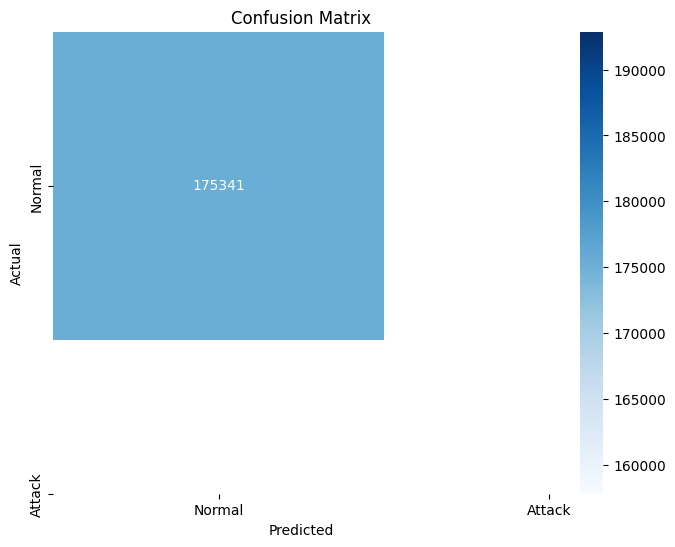

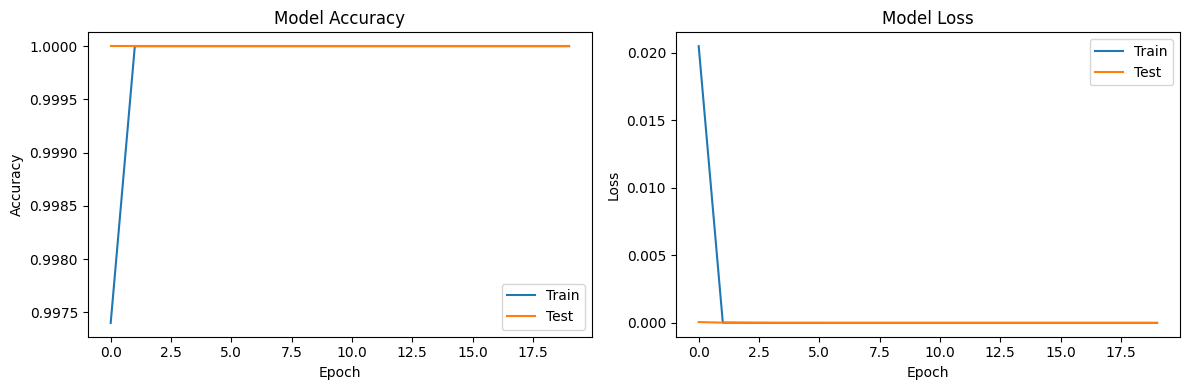



Model saved to Google Drive as '/content/drive/MyDrive/lstm_nids_unsw_nb15.h5'
Predictions saved to Google Drive as 'lstm_predictions.csv'


In [9]:

# Run the main function
if __name__ == "__main__":
    main()

In [10]:
from google.colab import auth
auth.authenticate_user()

!git config --global user.email "syedkhizerhaider@gmail.com"
!git config --global user.name "Khizer Haider"


In [15]:
!git clone "https://github.com/khizerhaider/NIDS.git"

Cloning into 'NIDS'...
fatal: could not read Username for 'https://github.com': No such device or address


# New Section